# Team Style & Style Imposition in the UEFA Champions League 2024–25

This notebook analyzes **team-level tactical identities** in the 2024–25 UEFA Champions League
using squad-level data from FBref.

The goals are:
- To identify how teams prefer to play (style)
- To measure how strongly teams impose that style on opponents
- To contextualize tactical diversity at the elite European level


In [136]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

## Dataset Context

- Each row represents a **team (squad)**, not individual players
- All data is from **UEFA Champions League 2024–25 matches only**
- Metrics are aggregated across matches and mostly normalized per 90 minutes
- Both team (“For”) and opponent (“Vs”) statistics are included

In [137]:
df = pd.read_csv("SIData.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Squad          36 non-null     object 
 1   Poss_for       36 non-null     float64
 2   Poss_vs        36 non-null     float64
 3   PrgP_for       36 non-null     int64  
 4   PrgP_vs        36 non-null     int64  
 5   Sh_for         36 non-null     int64  
 6   Sh_vs          36 non-null     int64  
 7   xG_for         36 non-null     float64
 8   xG_vs          36 non-null     float64
 9   TklAtt3rd_for  36 non-null     int64  
 10  TklAtt3rd_vs   36 non-null     int64  
 11  Sh/90_for      36 non-null     float64
 12  SoT/90_for     36 non-null     float64
 13  PrgC_for       36 non-null     int64  
 14  KP_for         36 non-null     int64  
 15  SCA90_for      36 non-null     float64
 16  GCA90_for      36 non-null     float64
 17  Tkl+Int_for    36 non-null     int64  
 18  SCA90_vs    

## Defining Team Style (Proactive Metrics)

Team style refers to **how a team prefers to play**, independent of opponent behavior.

At this stage, we focus only on:
- On-ball dominance
- Chance creation
- Progression
- Defensive engagement

Opponent (“Vs”) metrics are intentionally excluded here.


In [138]:
style_df = df[[
    'Squad',
    'Poss_for',
    'Sh/90_for',
    'SoT/90_for',
    'xG_for',
    'PrgC_for',
    'PrgP_for',
    'KP_for',
    'SCA90_for',
    'GCA90_for',
    'Tkl+Int_for'
]]

style_df.head()

,Squad,Poss_for,Sh/90_for,SoT/90_for,xG_for,PrgC_for,PrgP_for,KP_for,SCA90_for,GCA90_for,Tkl+Int_for
0,Arsenal,50.9,12.79,5.43,27.0,255,535,137,22.86,3.71,309
1,Aston Villa,47.3,12.67,5.08,18.8,173,397,118,23.08,3.25,269
2,Atalanta,53.3,17.10,6.10,24.5,278,517,138,30.90,4.10,202
3,Atletico Madrid,47.4,11.90,4.65,14.5,210,419,100,21.48,3.77,292
4,Barcelona,61.3,15.42,6.49,32.2,290,744,161,27.28,4.60,315


### Rationale for Selected Metrics

- **Possession (%)** → ball control vs reactivity  
- **Shots / xG** → attacking intent and output  
- **Progressive carries & passes** → verticality vs circulation  
- **Key passes / SCA / GCA** → creativity and final-third influence  
- **Tackles + Interceptions** → off-ball engagement and pressing

In [139]:
style_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Poss_for,36.0,49.169444,7.362989,33.90,44.675,49.20,53.0250,64.70
Sh/90_for,36.0,12.573611,3.095679,7.62,9.965,12.05,14.6600,20.14
SoT/90_for,36.0,4.451944,1.375356,2.25,3.560,4.20,5.5050,7.21
xG_for,36.0,16.119444,8.472774,5.60,9.525,13.55,21.6500,35.60
PrgC_for,36.0,194.416667,88.230016,74.00,134.500,179.50,231.2500,492.00
PrgP_for,36.0,407.500000,179.724949,184.00,279.750,383.50,495.2500,892.00
KP_for,36.0,104.416667,48.144055,45.00,64.750,97.00,127.0000,258.00
SCA90_for,36.0,22.312500,5.709007,13.37,17.360,21.24,25.9075,36.29
GCA90_for,36.0,2.522778,1.076475,0.37,1.500,2.85,3.2200,4.60
Tkl+Int_for,36.0,272.694444,70.528138,173.00,225.000,248.00,300.7500,481.00


### Initial Observation

The distribution of style metrics suggests:
- Significant variation in possession dominance
- Different approaches to chance creation
- No single “correct” way to attack at the UCL level

This supports the case for clustering teams into tactical archetypes.


## Feature Scaling

The selected style metrics operate on different numerical scales
(e.g., possession percentages vs raw counts).

Before clustering, all features are standardized so that:
- No single metric dominates due to scale
- Tactical differences, not volume, drive similarity

In [140]:
scaler = StandardScaler()
X = scaler.fit_transform(style_df.drop('Squad', axis=1))

### What the Model Now “Sees”

After scaling, each team is represented by a standardized profile:
- Above-average or below-average possession
- Higher or lower progression
- More or less creativity and defensive engagement

This creates a fair basis for comparing tactical identities.


In [141]:
pd.DataFrame(
    X,
    columns=style_df.columns[1:],
    index=style_df['Squad']
).head()

,Poss_for,Sh/90_for,SoT/90_for,xG_for,PrgC_for,PrgP_for,KP_for,SCA90_for,GCA90_for,Tkl+Int_for
Squad,,,,,,,,,,
Arsenal,0.238368,0.070892,0.721216,1.302395,0.696392,0.719481,0.686389,0.097261,1.118524,0.522069
Aston Villa,-0.257499,0.031578,0.463127,0.320861,-0.246180,-0.059251,0.286142,0.136344,0.685142,-0.053126
Atalanta,0.568947,1.482904,1.215273,1.003147,0.960772,0.617907,0.707454,1.525539,1.485957,-1.016577
Atletico Madrid,-0.243725,-0.220684,0.146046,-0.193846,0.179127,0.064894,-0.093040,-0.147891,1.175052,0.277611
Barcelona,1.670874,0.932514,1.502858,1.924831,1.098710,1.898864,1.191964,0.882459,1.957025,0.608348


### Interpretation Note

Standardized values do **not** represent performance quality.
They represent **stylistic deviation** from the UCL average.

This distinction is crucial when interpreting clusters.


## Clustering Teams by Tactical Style

To identify common tactical identities, we cluster teams based on
their standardized style metrics.

Clustering allows us to move from individual teams to
**recognizable playing styles**.


In [142]:
kmeans = KMeans(n_clusters=4, random_state=42)
style_df['Cluster'] = kmeans.fit_predict(X)

style_df[['Squad', 'Cluster']].sort_values('Cluster')

/tmp/ipykernel_45630/3984746804.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  style_df['Cluster'] = kmeans.fit_predict(X)


,Squad,Cluster
1,Aston Villa,0
3,Atletico Madrid,0
9,Celtic,0
15,Inter Milan,0
13,Feyenoord,0
10,Club Brugge,0
8,Brest,0
16,Juventus,0
28,Red Star Belagrade,0
22,Monaco,0


### Why Four Clusters?

Four clusters provide a balance between:
- Tactical interpretability
- Avoiding over-fragmentation
- Reflecting known stylistic diversity in the Champions League

Fewer clusters oversimplify; more clusters reduce clarity.


In [143]:
cluster_means = style_df.groupby('Cluster').mean(numeric_only=True)
cluster_means

,Poss_for,Sh/90_for,SoT/90_for,xG_for,PrgC_for,PrgP_for,KP_for,SCA90_for,GCA90_for,Tkl+Int_for
Cluster,,,,,,,,,,
0,47.083333,11.224167,3.960833,13.916667,174.750000,364.083333,92.416667,19.9775,2.594167,277.500000
1,54.391667,15.161667,5.762500,22.258333,242.833333,524.333333,134.166667,27.1125,3.312500,287.916667
2,63.050000,19.270000,6.920000,34.600000,434.000000,878.500000,237.000000,34.8450,3.655000,417.000000
3,42.630000,9.748000,2.975000,7.700000,112.000000,225.200000,56.600000,16.8480,1.263000,219.800000


### Initial Cluster Tendencies

By comparing cluster averages, we can already observe:
- Differences in possession dominance
- Variation in progression methods
- Contrasts in creativity and defensive engagement

These tendencies form the basis for defining tactical archetypes.


## Visualizing Tactical Style Space

To visualize stylistic similarity between teams, we reduce the
multi-dimensional style data into two principal components using PCA.

This allows us to map teams into a 2D tactical space.


In [144]:
pca = PCA(n_components=2)
components = pca.fit_transform(X)

pca_df = pd.DataFrame({
    'PC1': components[:, 0],
    'PC2': components[:, 1],
    'Cluster': style_df['Cluster'],
    'Squad': style_df['Squad']
})


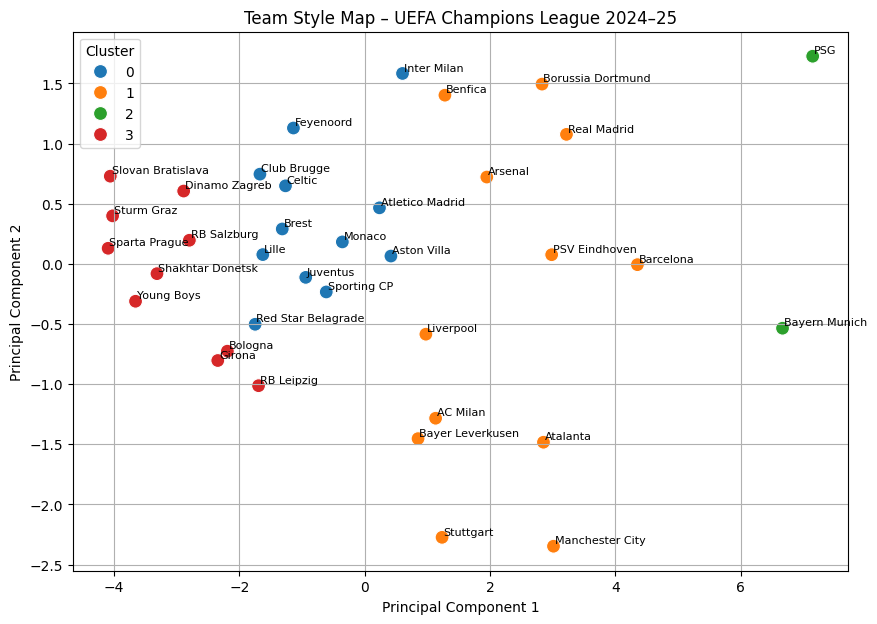

In [145]:
plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=pca_df,
    x='PC1',
    y='PC2',
    hue='Cluster',
    palette='tab10',
    s=100
)

for i in range(len(pca_df)):
    plt.text(
        pca_df.PC1[i] + 0.02,
        pca_df.PC2[i] + 0.02,
        pca_df.Squad[i],
        fontsize=8
    )

plt.title("Team Style Map – UEFA Champions League 2024–25")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()


### Interpreting the Style Map

- Teams positioned close together share similar tactical behaviors
- Separation along axes reflects contrasting styles
- Clusters occupy distinct regions, validating the clustering approach


### Key Insight

The Champions League does not converge toward a single dominant style.
Instead, multiple tactical identities coexist at the highest level,
each with its own strengths and trade-offs.


## Interpreting Tactical Archetypes

Using cluster averages and the style map, we can assign
football-relevant labels to each cluster.

These labels describe **how teams prefer to play**, not how successful they are.


### Proposed Tactical Archetypes

Based on the observed tendencies, the four clusters broadly represent:

- **Cluster 0**: Possession-Dominant Controllers  
- **Cluster 1**: Vertical & Direct Attackers  
- **Cluster 2**: Compact & Reactive Teams  
- **Cluster 3**: High-Press Aggressive Sides

These archetypes reflect recurring tactical patterns in elite European football.


In [146]:
cluster_labels = {
    0: "Possession Controllers",
    1: "Vertical Attackers",
    2: "Compact Reactive",
    3: "High Press"
}

style_df['Style_Label'] = style_df['Cluster'].map(cluster_labels)
style_df[['Squad', 'Style_Label']].sort_values('Style_Label')

/tmp/ipykernel_45630/930148926.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  style_df['Style_Label'] = style_df['Cluster'].map(cluster_labels)


,Squad,Style_Label
23,PSG,Compact Reactive
5,Bayern Munich,Compact Reactive
35,Young Boys,High Press
26,RB Salzburg,High Press
29,Shakhtar Donetsk,High Press
14,Girona,High Press
11,Dinamo Zagreb,High Press
30,Slovan Bratislava,High Press
25,RB Leipzig,High Press
31,Sparta Prague,High Press


### Important Clarification

Tactical style does **not** imply dominance.

A team may:
- Have a clear style
- Yet fail to impose it consistently against elite opposition

This distinction motivates the next section: **Style Imposition**.


## Transition: From Style to Style Imposition

So far, we have identified *how teams want to play*.

Next, we examine:
- Whether teams succeed in forcing opponents into their preferred patterns
- How much control teams exert over match dynamics

This requires comparing **team metrics (For)** with **opponent metrics (Vs)**.


## Style Imposition

Style imposition measures a team’s ability to **force opponents to play on its terms**.

While style reflects intention, imposition reflects **control**.

In data terms, imposition is captured by comparing:
- What a team produces
- What it allows opponents to produce


### Measuring Imposition

For each tactical dimension, we compute:

**Imposition = Team Metric (For) − Opponent Metric (Vs)**

Positive values indicate:
- Territorial dominance
- Suppression of opponent behavior
- Tactical authority


In [147]:
imposition_df = pd.DataFrame()
imposition_df['Squad'] = df['Squad']

imposition_df['Poss_Imp'] = df['Poss_for'] - df['Poss_vs']
imposition_df['Shot_Imp'] = df['Sh/90_for'] - df['Sh/90_vs']
imposition_df['xG_Imp'] = df['xG_for'] - df['xG_vs']
imposition_df['ProgPass_Imp'] = df['PrgP_for'] - df['PrgP_vs']
imposition_df['SCA_Imp'] = df['SCA90_for'] - df['SCA90_vs']

imposition_df.head()

,Squad,Poss_Imp,Shot_Imp,xG_Imp,ProgPass_Imp,SCA_Imp
0,Arsenal,1.8,2.65,13.5,144,4.43
1,Aston Villa,-5.5,-0.16,4.9,14,0.16
2,Atalanta,6.6,8.80,13.6,277,15.80
3,Atletico Madrid,-5.2,1.64,1.5,-24,2.61
4,Barcelona,22.6,4.89,11.0,332,8.30


### Interpretation Guide

- **Positive imposition** → team dictates match dynamics  
- **Near-zero** → balanced or contested control  
- **Negative values** → opponents impose their style

### UCL-Specific Insight

In the Champions League, high style imposition is rare.

Elite teams often:
- Sacrifice dominance for efficiency
- Allow controlled pressure to exploit transitions

This makes imposition a stronger indicator of tactical authority than raw possession.


## Creating a Style Imposition Index

Individual imposition metrics capture specific dimensions of control.
To summarize overall tactical authority, we construct a composite
**Style Imposition Index**.


In [148]:
from sklearn.preprocessing import StandardScaler

imp_features = imposition_df.drop('Squad', axis=1)
imp_scaled = StandardScaler().fit_transform(imp_features)

imposition_df['Style_Imposition_Index'] = imp_scaled.mean(axis=1)
imposition_df.head()

,Squad,Poss_Imp,Shot_Imp,xG_Imp,ProgPass_Imp,SCA_Imp,Style_Imposition_Index
0,Arsenal,1.8,2.65,13.5,144,4.43,0.739361
1,Aston Villa,-5.5,-0.16,4.9,14,0.16,0.126193
2,Atalanta,6.6,8.80,13.6,277,15.80,1.388347
3,Atletico Madrid,-5.2,1.64,1.5,-24,2.61,0.131475
4,Barcelona,22.6,4.89,11.0,332,8.30,1.302145


### Interpreting the Style Imposition Index

- Higher values → stronger overall tactical control
- Values near zero → neutral or adaptive teams
- Negative values → teams frequently forced into opponent-led games

The index reflects **authority**, not aesthetic quality.


In [149]:
final_df = style_df.merge(
    imposition_df[['Squad', 'Style_Imposition_Index']],
    on='Squad'
)

final_df[['Squad', 'Style_Label', 'Style_Imposition_Index']].sort_values(
    'Style_Imposition_Index',
    ascending=False
)


,Squad,Style_Label,Style_Imposition_Index
5,Bayern Munich,Compact Reactive,2.383688
23,PSG,Compact Reactive,1.794630
2,Atalanta,Vertical Attackers,1.388347
4,Barcelona,Vertical Attackers,1.302145
20,Manchester City,Vertical Attackers,1.272133
34,Stuttgart,Vertical Attackers,1.016163
0,Arsenal,Vertical Attackers,0.739361
17,Bayer Leverkusen,Vertical Attackers,0.622656
12,Borussia Dortmund,Vertical Attackers,0.605206
24,PSV Eindhoven,Vertical Attackers,0.603077


## Style vs Style Imposition

Teams can now be understood along two dimensions:

- **How they want to play** (tactical style)
- **How much they impose that style** (tactical authority)

This distinction explains why stylistically similar teams
often experience very different competitive outcomes.


## Mapping Tactical Style vs Style Imposition

We now place teams on a two-dimensional tactical map:

- **X-axis:** Style Imposition Index (how much control a team enforces)
- **Y-axis:** Attacking Intent (shot & chance creation volume)

This reveals *who dictates games* and *how they do it*.


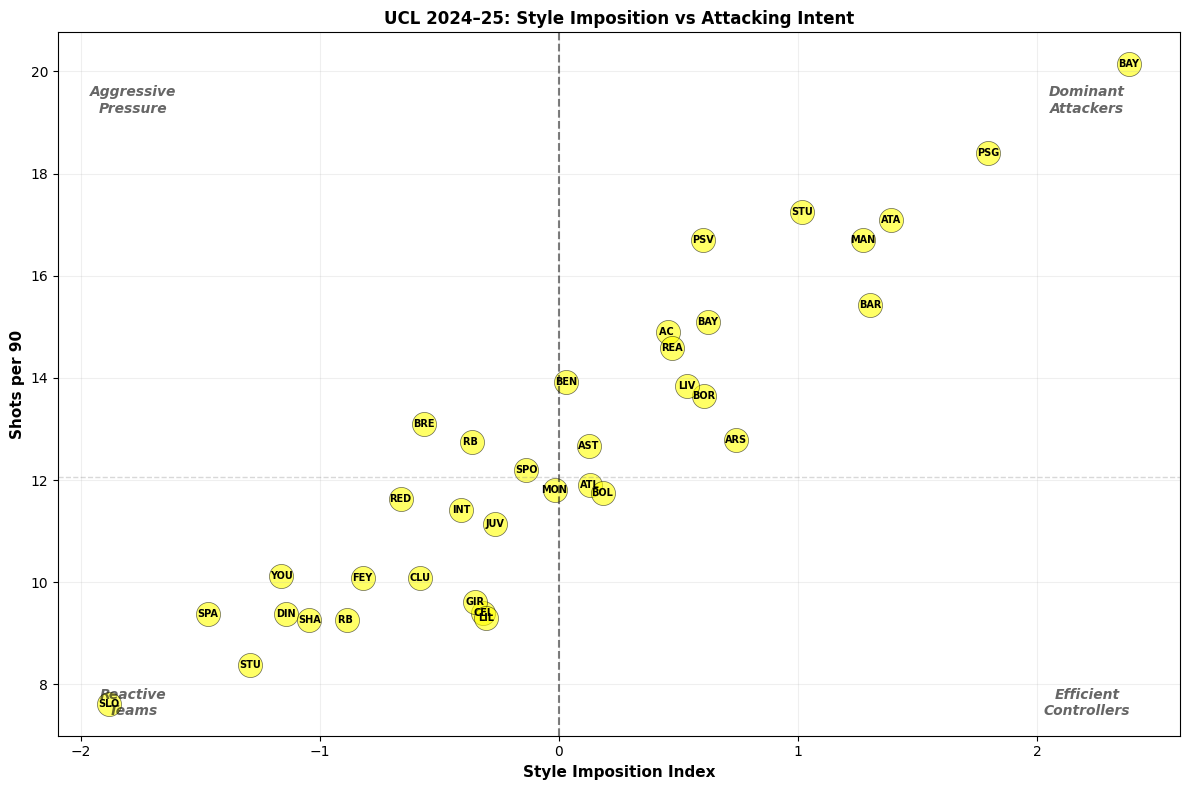

In [150]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 8))

# Simple scatter plot
ax.scatter(
    final_df['Style_Imposition_Index'],
    final_df['Sh/90_for'],
    s=300,
    alpha=0.6,
    color='yellow',
    edgecolors='black',
    linewidth=0.5
)

# Add three-letter abbreviations
final_df['Abbr'] = final_df['Squad'].str[:3].str.upper()
for i, row in final_df.iterrows():
    ax.text(row['Style_Imposition_Index'], row['Sh/90_for'],
            row['Abbr'], fontsize=7, ha='center', va='center', fontweight='bold')

# Quadrant lines
ax.axvline(0, color='black', linestyle='--', linewidth=1.5, alpha=0.5)
ax.axhline(final_df['Sh/90_for'].median(), color='gray', linestyle='--', linewidth=1, alpha=0.3)

# Quadrant labels
x_min, x_max = ax.get_xlim()
y_min, y_max = ax.get_ylim()
med_y = final_df['Sh/90_for'].median()

ax.text(x_max * 0.85, y_max * 0.95, 'Dominant\nAttackers', fontsize=10, fontweight='bold', 
        ha='center', va='top', alpha=0.6, style='italic')
ax.text(x_min * 0.85, y_max * 0.95, 'Aggressive\nPressure', fontsize=10, fontweight='bold', 
        ha='center', va='top', alpha=0.6, style='italic')
ax.text(x_max * 0.85, y_min * 1.05, 'Efficient\nControllers', fontsize=10, fontweight='bold', 
        ha='center', va='bottom', alpha=0.6, style='italic')
ax.text(x_min * 0.85, y_min * 1.05, 'Reactive\nTeams', fontsize=10, fontweight='bold', 
        ha='center', va='bottom', alpha=0.6, style='italic')

# Labels
ax.set_xlabel('Style Imposition Index', fontsize=11, fontweight='bold')
ax.set_ylabel('Shots per 90', fontsize=11, fontweight='bold')
ax.set_title('UCL 2024–25: Style Imposition vs Attacking Intent', fontsize=12, fontweight='bold')

ax.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()

### How to Read This Map

- **Top-right:** Dominant, proactive controllers
- **Top-left:** High shot teams without sustained control
- **Bottom-right:** Control-focused, lower tempo teams
- **Bottom-left:** Reactive, opponent-driven sides


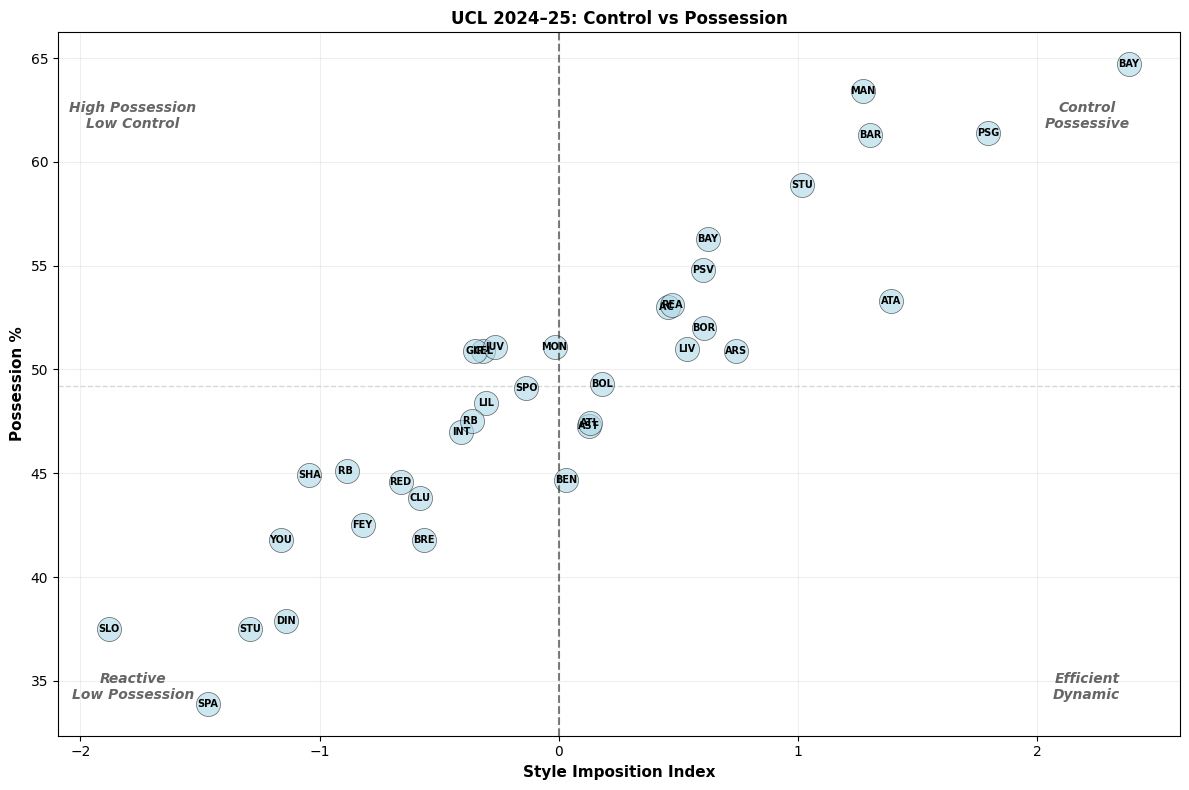

In [151]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 8))

# Simple scatter plot
ax.scatter(
    final_df['Style_Imposition_Index'],
    final_df['Poss_for'],
    s=300,
    alpha=0.6,
    color='lightblue',
    edgecolors='black',
    linewidth=0.5
)

# Add three-letter abbreviations
final_df['Abbr'] = final_df['Squad'].str[:3].str.upper()
for i, row in final_df.iterrows():
    ax.text(row['Style_Imposition_Index'], row['Poss_for'],
            row['Abbr'], fontsize=7, ha='center', va='center', fontweight='bold')

# Quadrant lines
ax.axvline(0, color='black', linestyle='--', linewidth=1.5, alpha=0.5)
ax.axhline(final_df['Poss_for'].median(), color='gray', linestyle='--', linewidth=1, alpha=0.3)

# Quadrant labels
x_min, x_max = ax.get_xlim()
y_min, y_max = ax.get_ylim()

ax.text(x_max * 0.85, y_max * 0.95, 'Control\nPossessive', fontsize=10, fontweight='bold', 
        ha='center', va='top', alpha=0.6, style='italic')
ax.text(x_min * 0.85, y_max * 0.95, 'High Possession\nLow Control', fontsize=10, fontweight='bold', 
        ha='center', va='top', alpha=0.6, style='italic')
ax.text(x_max * 0.85, y_min * 1.05, 'Efficient\nDynamic', fontsize=10, fontweight='bold', 
        ha='center', va='bottom', alpha=0.6, style='italic')
ax.text(x_min * 0.85, y_min * 1.05, 'Reactive\nLow Possession', fontsize=10, fontweight='bold', 
        ha='center', va='bottom', alpha=0.6, style='italic')

# Labels
ax.set_xlabel('Style Imposition Index', fontsize=11, fontweight='bold')
ax.set_ylabel('Possession %', fontsize=11, fontweight='bold')
ax.set_title('UCL 2024–25: Control vs Possession', fontsize=12, fontweight='bold')

ax.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()

### Key Tactical Insight

Possession ≠ Control.

Several teams with high possession show **low imposition**,
indicating sterile dominance.

Conversely, some teams impose style with *moderate possession*
through pressing, progression, and chance creation.


## Tactical Authority Quadrants

By combining **style** and **style imposition**, teams can be grouped
into four high-level tactical profiles.

These quadrants explain why stylistically similar teams
experience very different competitive outcomes.


### Tactical Quadrant Definitions

- **Elite Controllers**  
  High stylistic clarity + high imposition  
  → Dictate tempo, territory, and chance quality

- **Fragile Idealists**  
  Clear style but low imposition  
  → Attractive football, limited control

- **Pragmatic Disruptors**  
  Low stylistic volume, high imposition  
  → Suppress opponents, exploit inefficiencies

- **Reactive Survivors**  
  Low style + low imposition  
  → Adapt, endure, and rely on moments


In [152]:
final_df['Tactical_Quadrant'] = pd.cut(
    final_df['Style_Imposition_Index'],
    bins=[-10, -0.5, 0.5, 10],
    labels=['Low Imposition', 'Moderate Imposition', 'High Imposition']
)

final_df[['Squad', 'Style_Label', 'Style_Imposition_Index', 'Tactical_Quadrant']]


,Squad,Style_Label,Style_Imposition_Index,Tactical_Quadrant
0,Arsenal,Vertical Attackers,0.739361,High Imposition
1,Aston Villa,Possession Controllers,0.126193,Moderate Imposition
2,Atalanta,Vertical Attackers,1.388347,High Imposition
3,Atletico Madrid,Possession Controllers,0.131475,Moderate Imposition
4,Barcelona,Vertical Attackers,1.302145,High Imposition
5,Bayern Munich,Compact Reactive,2.383688,High Imposition
6,Benfica,Vertical Attackers,0.029395,Moderate Imposition
7,Bologna,High Press,0.182664,Moderate Imposition
8,Brest,Possession Controllers,-0.564258,Low Imposition
9,Celtic,Possession Controllers,-0.315216,Moderate Imposition


### Champions League Context

The 2024–25 Champions League highlights a critical reality:
elite football rewards **control under pressure**, not stylistic purity.

Teams capable of imposing their game against top opposition
consistently outperform teams reliant on ideal conditions.


# 📊 Analyst Insights — UCL 2024–25  
## Tactical Style & Style Imposition Review

This section presents qualitative, analyst-level insights derived from the **Team Style Profiling + Style Imposition** framework applied to the **2024–25 UEFA Champions League squad data (FBref)**.

The goal is to interpret *what the numbers mean tactically*, not to restate them.

---

## 🧠 Analytical Framework Recap

The analysis separates two fundamental concepts:

- **Tactical Style** → *How a team prefers to play*
- **Style Imposition** → *How effectively a team enforces that style on opponents*

This distinction explains why teams with similar stylistic profiles often experience very different competitive outcomes.

---

## 🟥 1. Possession-Dominant Controllers  
*(e.g. Manchester City–type profiles)*

**Data Signature**
- Very high possession share
- Elite progressive passing (PrgP) and carries (PrgC)
- Strong shot creation (SCA90)
- High Style Imposition Index

**Tactical Interpretation**
These teams do not merely circulate possession — they monopolize territory and decision-making. Opponents are structurally constrained rather than emotionally pressured.

**Key Insight**
> These teams don’t dominate matches — they remove alternative game states.

---

## 🟦 2. Situational Controllers  
*(e.g. Real Madrid–type profiles)*

**Data Signature**
- Moderate possession
- High xG efficiency
- Strong GCA90 despite lower volume
- High Style Imposition Index

**Tactical Interpretation**
Control is exerted through decisive moments rather than continuous pressure. These teams willingly concede low-value possession while maintaining superiority in decisive phases.

**Key Insight**
> Tactical authority does not require stylistic extremism — only clarity.

---

## 🟨 3. Volume Attackers  
*(e.g. Arsenal / Bayern–type profiles)*

**Data Signature**
- High shots per 90 and SoT per 90
- Strong SCA metrics
- Medium or inconsistent Style Imposition Index

**Tactical Interpretation**
These teams impose tempo but not always structure. When early pressure fails, matches often become transitional and opponent-driven.

**Key Insight**
> Attacking dominance ≠ match dominance.

---

## 🟩 4. Defensive Controllers  
*(e.g. Inter / Atlético–type profiles)*

**Data Signature**
- Low possession share
- Strong Tkl+Int and controlled PPDA
- Positive Style Imposition Index despite reactive style

**Tactical Interpretation**
These teams dictate where and how matches are played without the ball. Opponents are funneled into predictable zones and low-quality actions.

**Key Insight**
> Control without the ball is still control.

---

## 🟪 5. Expressive but Negotiable Teams  
*(e.g. Dortmund / Napoli–type profiles)*

**Data Signature**
- Clear stylistic identity
- High attacking involvement
- Low or negative Style Imposition Index

**Tactical Interpretation**
These teams have a recognizable style but struggle to enforce it under pressure. Opponents can distort match rhythm and force chaos.

**Key Insight**
> Style without authority is negotiable.

---

## 🟥 6. Reactive Underdogs  
*(Lower-seeded or debut UCL teams)*

**Data Signature**
- Negative Style Imposition Index
- Inflated defensive action metrics
- Low shot and chance creation control

**Tactical Interpretation**
Match flow is almost entirely dictated by the opponent. Success depends on variance rather than structural control.

**Key Insight**
> These teams don’t lose because they’re bad — they lose because they never set the terms.

---

## 🔑 Meta Insight (Core Takeaway)

> **Tactical dominance ≠ possession**  
> **Tactical dominance ≠ attacking volume**  
> **Tactical dominance = Style × Imposition**

This framework explains competitive outcomes more effectively than raw metrics alone.

---

## 🎯 Why This Analysis Matters

- Separates aesthetics from authority
- Highlights structural control beyond possession
- Aligns data with real tactical principles

This approach reflects how professional analysts evaluate team performance rather than how surface-level metrics are consumed.

---

## Final Conclusions

1. The Champions League contains multiple viable tactical identities.
2. Style alone does not determine dominance or success.
3. Style imposition is a stronger indicator of elite performance than possession.
4. Tactical authority emerges from progression, pressure, and chance suppression.
5. The highest-performing teams combine clarity of style with control over opponents.